In [2]:
import jax.numpy as np
from jax import jit
from discopy import Tensor
Tensor.np = np
import discopy
from discopy import Word, Ty, Cup, Id, grammar
from sympy.abc import phi
from time import time
from discopy.grammar import brute_force
import numpy as np
from discopy import drawing
from discopy.quantum import Id, Rz, CX, CRz
from sympy.abc import symbols, phi
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP,circuit, Bra
from discopy import CircuitFunctor, qubit, Functor
from sympy import default_sort_key

# Spam Classification for Email

Here we generate a vocabulary of words with positional tags.  This is translated into a set of data with correct, and incorrect sentences which correspond to lables 1's and 0's respectively.  This data is split up into a training,development, and test set.  The sentences are translated along with their grammer are translated into diagrams with discopy, and then into corresponding parameterized quantum circuits.  We then use the data labels and  a classical optimizer to optimize these circuits, and then calculate a classification value 1 or 0 for each sentence.  This allows use to test different sentences of similar for, but with different vocabulary to identify spam vs real email sentences for example.

# Task 2

Below we generate the vocabulary, grammer, and corresponding labels that we want to test

In [3]:
#******************************************
# Generate your corpus
#******************************************
# sentences can be of the `word1 word2 word3 ...`
# if you are generating the diagrams using templates
# then you may want to consider adding POS tags (N, V, Adj) for each word
# labels should be of the form [0,1] or [1,0] for binary classification

s, n = Ty('s'), Ty('n')
Jaz = Word('Alice', n)
Jane = Word('Janezesa', n)
Juniper = Word('Juniper', n)
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
despises = Word('depises', n.r @ s @ n.l)
tolerates = Word('tolerdfates', n.r @ s @ n.l)
glares_at = Word('glares at', n.r @ s @ n.l)
attacks = Word('attacks', n.r @ s @ n.l)
flees = Word('flees', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob,Jaz,Jane,Juniper,despises,tolerates,glares_at,attacks,flees]#, who, is_rich]

num_sentences = 26

gen, n_sentences = brute_force(*vocab), num_sentences
sentences= list()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word))
    sentences.append(sentence)
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice loves Alice
Alice loves Bob
Alice loves Alice
Alice loves Janezesa
Alice loves Juniper
Alice depises Alice
Alice depises Bob
Alice depises Alice
Alice depises Janezesa
Alice depises Juniper
Alice tolerdfates Alice
Alice tolerdfates Bob
Alice tolerdfates Alice
Alice tolerdfates Janezesa
Alice tolerdfates Juniper
Alice glares at Alice
Alice glares at Bob
Alice glares at Alice
Alice glares at Janezesa
Alice glares at Juniper
Alice attacks Alice
Alice attacks Bob
Alice attacks Alice
Alice attacks Janezesa
Alice attacks Juniper
Alice flees Alice

0.36 seconds to generate 26 sentences.


## Datasets
Here we auto split our data sentences into a train,dev, and test set allong with corresponding labels sets for each.

In [4]:
hl = int(num_sentences/4)
hlp = 3*hl

train_sentences = sentences[0:hlp]
hd = int((num_sentences - hlp)/2)
dev_sentences = sentences[hlp:hlp+hd]
test_sentences = sentences[hlp+hd:]

train_labels = [1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,1,1]
dev_labels = [0,1,1,1]
test_labels = [1,0,1,1]

train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

#print(len(train_labels),len(dev_sentences),len(test_sentences))
#print(train_sentences)
#print(dev_sentences)
#print(test_sentences)
print(type(train_sentences),train_sentences[2])

<class 'list'> Alice loves Alice


# Here we generate sentence templates

Another option is to generate the diagrams via the website: https://qnlp.cambridgequantum.com/generate.html.

We also, generate our own Ansatz states below, but you can also use the builtin Ansatz with the IQP Ansatz method:

https://discopy.readthedocs.io/en/main/discopy/quantum.circuit.html.


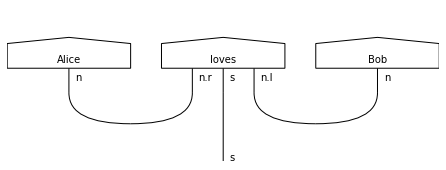

In [5]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

def sentence2diagram(one_sentence):
    w0,w1,w2 = sentence.split(' ')
    words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    return words >> cups

train_diagrams = [sentence2diagram(s) for s in train_sentences]
dev_diagrams = [sentence2diagram(s) for s in dev_sentences]
test_diagrams = [sentence2diagram(s) for s in test_sentences]

def NVN_example(w0, w1, w2):
    words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    return words >> cups

grammar.draw(NVN_example('Alice', 'loves', 'Bob'))

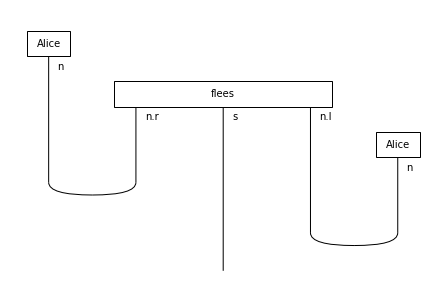

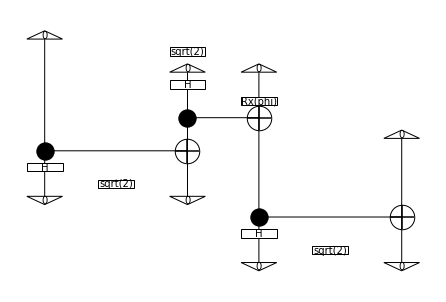

In [21]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.


# Ansatz for words with type `n`, e.g. 'Alice', 'Bob'



def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

# Ansatz for words with type `n.r @ s @ n.l`, e.g. 'loves'
def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)
sym = symbols("abc")
#params0 = np.array([0.5, 1.0])
params0 = np.array([0.5])

diagram2circuit = circuit.Functor(
    ob={s: qubit ** 0, n: qubit ** 1},
    ar={Alice: Ket(0),
        flees: transitive_ansatz(phi),
        loves: transitive_ansatz(phi),
        tolerates:transitive_ansatz(phi),
        despises:transitive_ansatz(phi),
        glares_at:transitive_ansatz(phi),
        attacks:transitive_ansatz(phi),
        Bob: Ket(1),
        who: GHZ,
        is_rich: intransitive_ansatz(params0[0])})


#pltest = (Alice @ loves @ Bob)
#dimdd = (diagram2circuit(pltest)>>Bra(0,0,0,0))
#pl = diagram2circuit(pltest)

l=diagram2circuit(train_diagrams[0])
train_diagrams[0].draw()

train_circuits = [diagram2circuit(d) for d in train_diagrams]
dev_circuits = [diagram2circuit(d) for d in dev_diagrams]
test_circuits = [diagram2circuit(d) for d in test_diagrams]

sym = symbols("abc")
params = np.array([0.5, 1.0])
circ = train_circuits[0]
from discopy.quantum import Ket, Bra
circ.draw()



# Task 3

Here we do an experiment to train our circuits and classify them as spam or not.

In [22]:
# These imports will come in handy when you want to run
# backend simulations.

# from qiskit import IBMQ
# from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

In [26]:
#******************************************
# Counting parameters in your model
#******************************************
circuits = train_circuits + dev_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.
parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)
parameters = [phi]
params = params0
print(parameters)
print(params)

[phi]
[0.5]


In [27]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = np.abs(predicts - 1e-9)
    predicts = predicts / predicts.sum()
    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)

    return cost

In [30]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = np.array([
            normalise(np.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
        return predictions

    return pred_fn
#print((train_circuits[0]).eval())

In [31]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
# onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(complex64[1])>with<DynamicJaxprTrace(level=0/1)>
While tracing the function pred_fn at /tmp/ipykernel_1755/1375126974.py:2 for jit, this concrete value was not available in Python because it depends on the value of the argument 'params'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [268]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [269]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [272]:
from noisyopt import minimizeSPSA
minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=2000, callback=dev_cost_fn)

     fun: DeviceArray(-0., dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 4000
     nit: 2000
 success: True
       x: DeviceArray([], dtype=float32)

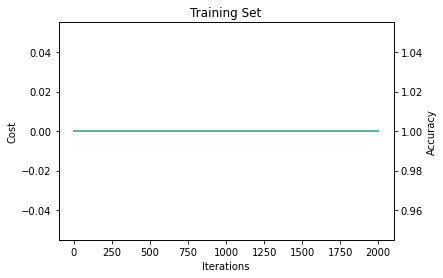

In [273]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

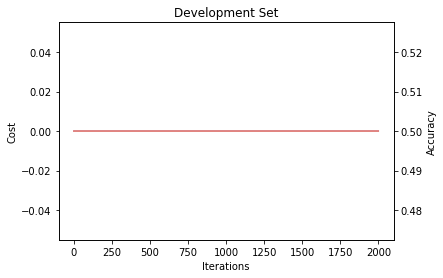

In [274]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

In [275]:
# when you are happy with the development set results
# run your model on the testing set

# for p in callback_params:
#     test_cost_fn(p)

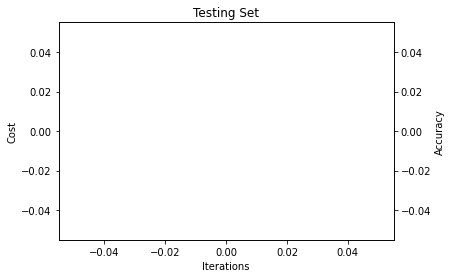

In [276]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()

# Test

amplitude:


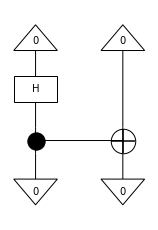

probability: 0.4999999701976776


In [259]:
from discopy.quantum import Bra

experiment = Ket(0, 0) >> circuit >> Bra(0, 0)

print("amplitude:")
experiment.draw(figsize=(2, 3))
amplitude = experiment.eval().array[0]

probability = abs(amplitude) ** 2
print("probability: {}".format(probability))